# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1000s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1064, 32, 20, 3)
(1064, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
266/266 [==============================] - 6s 9ms/step - loss: 2.0890 - accuracy: 0.3792
Epoch 2/500
266/266 [==============================] - 2s 9ms/step - loss: 1.4835 - accuracy: 0.5326
Epoch 3/500
266/266 [==============================] - 2s 9ms/step - loss: 1.1962 - accuracy: 0.6428
Epoch 4/500
266/266 [==============================] - 2s 9ms/step - loss: 0.8560 - accuracy: 0.7058
Epoch 5/500
266/266 [==============================] - 2s 9ms/step - loss: 0.8001 - accuracy: 0.7627
Epoch 6/500
266/266 [==============================] - 2s 9ms/step - loss: 0.7563 - accuracy: 0.7571
Epoch 7/500
266/266 [==============================] - 3s 10ms/step - loss: 0.6646 - accuracy: 0.7893
Epoch 8/500
266/266 [==============================] - 3s 10ms/step - loss: 0.5826 - accuracy: 0.8199
Epoch 9/500
266/266 [==============================] - 3s 11ms/step - loss: 0.4910 - accuracy: 0.8325 0s - loss:
Epoch 10/500
266/266 [==============================] - 3s 10ms/step - loss: 

266/266 [==============================] - 2s 9ms/step - loss: 0.0929 - accuracy: 0.9695
Epoch 80/500
266/266 [==============================] - 2s 8ms/step - loss: 0.1172 - accuracy: 0.9588
Epoch 81/500
266/266 [==============================] - 2s 9ms/step - loss: 0.1267 - accuracy: 0.9627
Epoch 82/500
266/266 [==============================] - 2s 8ms/step - loss: 0.1941 - accuracy: 0.9611
Epoch 83/500
266/266 [==============================] - 2s 9ms/step - loss: 0.1410 - accuracy: 0.9533
Epoch 84/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0777 - accuracy: 0.9776
Epoch 85/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0795 - accuracy: 0.9767
Epoch 86/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0779 - accuracy: 0.9724
Epoch 87/500
266/266 [==============================] - 3s 10ms/step - loss: 0.1087 - accuracy: 0.9597 0s - loss: 0.1064 - accu
Epoch 88/500
266/266 [==============================] - 2s 9ms/step -

266/266 [==============================] - 3s 10ms/step - loss: 0.0548 - accuracy: 0.9777
Epoch 157/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0786 - accuracy: 0.9744
Epoch 158/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0905 - accuracy: 0.9664
Epoch 159/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0634 - accuracy: 0.9793
Epoch 160/500
266/266 [==============================] - 3s 10ms/step - loss: 0.1317 - accuracy: 0.9672
Epoch 161/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0984 - accuracy: 0.9741
Epoch 162/500
266/266 [==============================] - 3s 9ms/step - loss: 0.0666 - accuracy: 0.9820
Epoch 163/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0918 - accuracy: 0.9738
Epoch 164/500
266/266 [==============================] - 3s 9ms/step - loss: 0.0806 - accuracy: 0.9763
Epoch 165/500
266/266 [==============================] - 3s 9ms/step - loss: 0.0

266/266 [==============================] - 3s 10ms/step - loss: 0.0308 - accuracy: 0.9905
Epoch 235/500
266/266 [==============================] - 3s 9ms/step - loss: 0.0451 - accuracy: 0.9877
Epoch 236/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0403 - accuracy: 0.9880
Epoch 237/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0398 - accuracy: 0.9895
Epoch 238/500
266/266 [==============================] - 3s 9ms/step - loss: 0.0538 - accuracy: 0.9783: 0s - loss: 0.0539 - accuracy
Epoch 239/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0626 - accuracy: 0.9795
Epoch 240/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0501 - accuracy: 0.9858
Epoch 241/500
266/266 [==============================] - 3s 10ms/step - loss: 0.1212 - accuracy: 0.9724
Epoch 242/500
266/266 [==============================] - 2s 9ms/step - loss: 0.0597 - accuracy: 0.9846
Epoch 243/500
266/266 [==============================

266/266 [==============================] - 2s 9ms/step - loss: 0.0483 - accuracy: 0.9864
Epoch 313/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0205 - accuracy: 0.9939
Epoch 314/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0660 - accuracy: 0.9865
Epoch 315/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0114 - accuracy: 0.9963
Epoch 316/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0489 - accuracy: 0.9859
Epoch 317/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0304 - accuracy: 0.9895
Epoch 318/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0211 - accuracy: 0.9919 0s -
Epoch 319/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0720 - accuracy: 0.9795
Epoch 320/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0605 - accuracy: 0.9856
Epoch 321/500
266/266 [==============================] - 3s 10ms/step - lo

266/266 [==============================] - 3s 10ms/step - loss: 0.0232 - accuracy: 0.9929
Epoch 391/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0405 - accuracy: 0.9908
Epoch 392/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0256 - accuracy: 0.9865
Epoch 393/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0583 - accuracy: 0.9883
Epoch 394/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0427 - accuracy: 0.9876
Epoch 395/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0168 - accuracy: 0.9964 
Epoch 396/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0235 - accuracy: 0.9922
Epoch 397/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0957 - accuracy: 0.9785
Epoch 398/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0200 - accuracy: 0.9889
Epoch 399/500
266/266 [==============================] - 3s 10ms/step - loss:

266/266 [==============================] - 3s 10ms/step - loss: 0.0416 - accuracy: 0.9881
Epoch 468/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0449 - accuracy: 0.9872
Epoch 469/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0356 - accuracy: 0.9913
Epoch 470/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0317 - accuracy: 0.9936
Epoch 471/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0449 - accuracy: 0.9946
Epoch 472/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0173 - accuracy: 0.9935
Epoch 473/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0581 - accuracy: 0.9862
Epoch 474/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0216 - accuracy: 0.9935
Epoch 475/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0285 - accuracy: 0.9924
Epoch 476/500
266/266 [==============================] - 3s 10ms/step - loss: 

### Learing result
 
* Visualization of the training and validation results

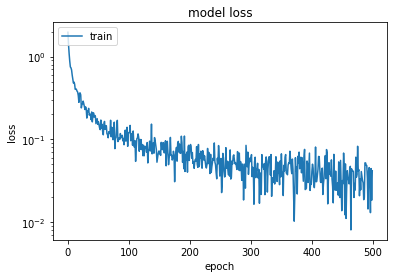

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

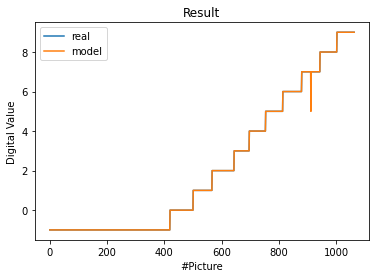

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp_whizi5n\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpm3x42445\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpm3x42445\assets


63824

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/7\7_ROI4_20210425-132406.jpg 7 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.